# Análise de Dados de Sensores para Classificação de Falhas em Motores Elétricos

Este projeto tem como objetivo a classificação so estado de operação de um motor elétrico baseado na análise de sensores.
As possivies classificações de operação são: normal, desbalanceado e defeito no rolamento inferior.

### Configuração do ambiente

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# configura o ambiente com GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 530 (delta 171), reused 129 (delta 94), pack-reused 269 (from 1)
Receiving objects: 100% (530/530), 170.56 KiB | 21.32 MiB/s, done.
Resolving deltas: 100% (273/273), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.8 MB/s eta 0:00:00
Installing RAPIDS remaining 24.6.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.0/478.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!nvidia-smi

Wed Oct 16 02:23:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   62C    P8              18W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


Define localizaçãoi dos arquivos do projeto no drive

In [ ]:
BASE_PATH ='/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc'

##### Instalação de bibliotecas adicionais

In [ ]:
!pip install scikeras
!pip install keras_tuner

### Importação de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import zipfile
from scipy import signal
import os
from scipy.fft import rfft, rfftfreq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Obtenção dos dados

In [ ]:
# Download dos arquivos
urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/imbalance.zip', BASE_PATH + '/data/imbalance.zip')
urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/normal.zip', BASE_PATH + '/data/normal.zip')
urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/underhang.zip', BASE_PATH + '/data/underhang.zip')

# extração dos arquivos
with zipfile.ZipFile(BASE_PATH + '/data/imbalance.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH + 'data')
with zipfile.ZipFile(BASE_PATH + '/data/normal.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH + 'data')
with zipfile.ZipFile(BASE_PATH + '/data/underhang.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH + 'data')

# excluir arquivos .zip
os.remove(BASE_PATH + '/data/normal.zip')
os.remove(BASE_PATH + '/data/imbalance.zip')
os.remove(BASE_PATH + '/data/underhang.zip')

### Tratamento dos dados

In [ ]:
feature_names = ['tacometro', 'rol_int_axial', 'rol_int_radial','rol_int_tangencial',
                 'rol_ext_axial', 'rol_ext_radial','rol_ext_tangencial', 'microfone']

In [ ]:
normal_sample = pd.read_csv(BASE_PATH + '/data/normal/61.44.csv', header=None, names=feature_names)
print(normal_sample.dtypes)

tacometro             float64
rol_int_axial         float64
rol_int_radial        float64
rol_int_tangencial    float64
rol_ext_axial         float64
rol_ext_radial        float64
rol_ext_tangencial    float64
microfone             float64
dtype: object


In [ ]:
def check_inconsistent_values(path_names):
    for file in path_names:
        data = pd.read_csv(file, header=None)
        nullValues = data.isnull().sum()
        inconsistent_type = data.dtypes != 'float64'
        if any(nullValues > 0):
            print('CSV file {} has null values'.format(file))
        if any(inconsistent_type):
            print('CSV file {} has inconsistent type'.format(file))


normal_file_names = glob.glob(BASE_PATH + '/data/normal/*.csv')
imbalance_file_names = glob.glob(BASE_PATH + '/data/imbalance/**/*.csv')
underhang_files_names = glob.glob(BASE_PATH + '/data/underhang/**/*.csv', recursive=True)

check_inconsistent_values(normal_file_names)
check_inconsistent_values(imbalance_file_names)
check_inconsistent_values(underhang_files_names)

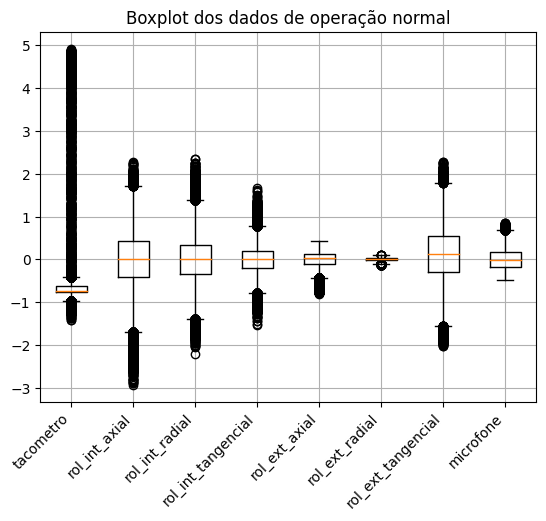

Número de outliers na coluna 0: 44210
Número de outliers na coluna 1: 2100
Número de outliers na coluna 2: 1642
Número de outliers na coluna 3: 2448
Número de outliers na coluna 4: 1813
Número de outliers na coluna 5: 797
Número de outliers na coluna 6: 642
Número de outliers na coluna 7: 390


In [ ]:
bp = plt.boxplot(normal_sample, labels=normal_sample.columns)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot dos dados de operação normal')
plt.grid(True)
plt.show()

for feature in range(len(normal_sample.columns)):
    # Obter os outliers (fliers)
    outliers = bp['fliers'][feature].get_ydata()

    # Contar os outliers
    num_outliers = len(outliers)

    # Imprimir o número de outliers para a feature
    print(f"Número de outliers na coluna {feature}: {num_outliers}")

In [ ]:
def plot_outliers(feature_data, feature_name):
  # Calcular o IQR e identificar outliers
  Q1 = feature_data.quantile(0.25)
  Q3 = feature_data.quantile(0.75)
  IQR = Q3 - Q1
  lower_limit_outliers = Q1 - 1.5 * IQR
  upper_limit_outliers = Q3 + 1.5 * IQR
  outliers = (feature_data < lower_limit_outliers) | (feature_data > upper_limit_outliers)

  # reduzir quantidade de dados para melhor visualização
  sample_size = len(feature_data) // 10
  sample_data = feature_data[:sample_size]
  sample_outliers = outliers[:sample_size]

  # Plotar a série temporal e destacar os outliers e limites dos dados considerados outliers
  plt.figure(figsize=(12, 6))
  plt.plot(sample_data, label='Dados')
  plt.scatter(sample_data.index[sample_outliers], sample_data[sample_outliers], color='red', label='Outliers')
  plt.axhline(y=lower_limit_outliers, color='blue', linestyle='--', label='Limite inferior outliers')
  plt.axhline(y=upper_limit_outliers, color='green', linestyle='--', label='Limite Superior outliers')
  plt.title(f'Dados do {feature_name} com Outliers Destacados')
  plt.xlabel('Amostras')
  plt.ylabel('Valores')
  plt.legend(loc='upper right')
  plt.show()

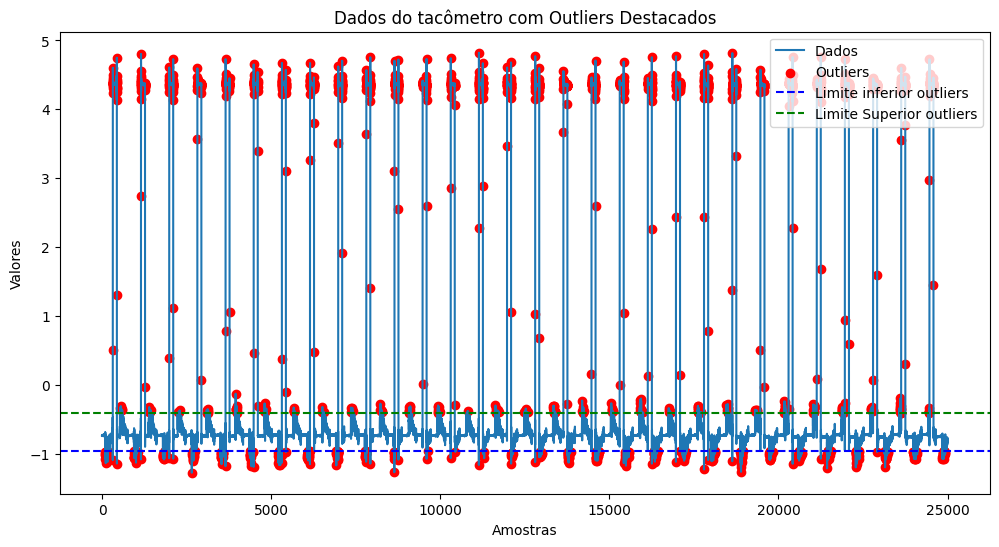

In [ ]:
feature_data = normal_sample['tacometro']
plot_outliers(feature_data, 'tacômetro')


In [ ]:
normal_sample[0].median()

-0.72733

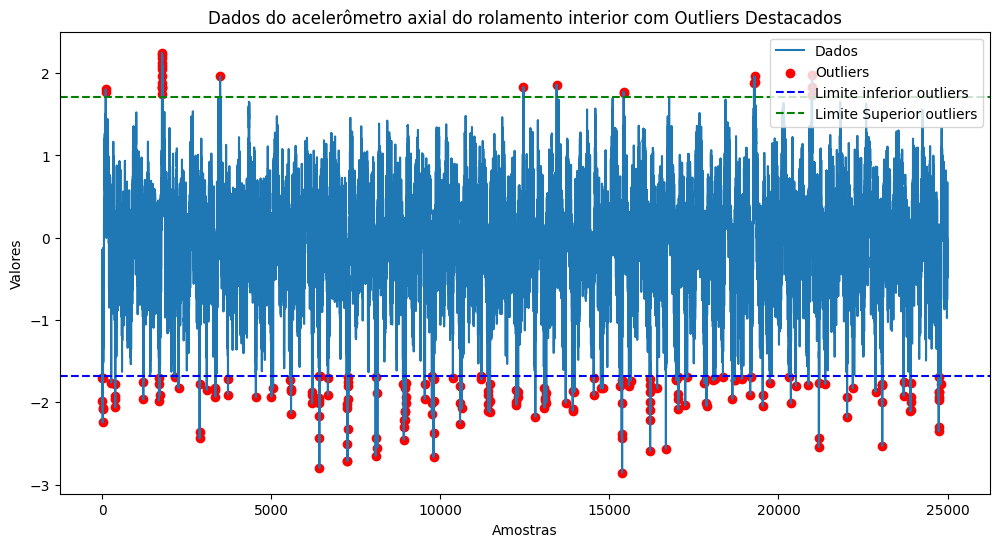

In [ ]:
feature_data = normal_sample['rol_int_axial']
plot_outliers(feature_data, 'acelerômetro axial do rolamento interior')

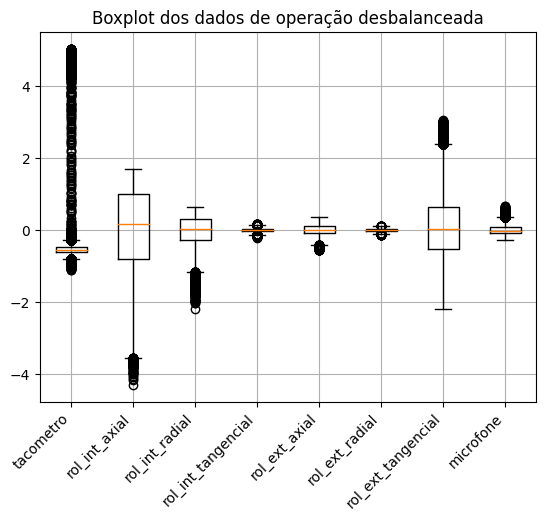

Número de outliers na coluna 0: 38410
Número de outliers na coluna 1: 85
Número de outliers na coluna 2: 399
Número de outliers na coluna 3: 1058
Número de outliers na coluna 4: 251
Número de outliers na coluna 5: 132
Número de outliers na coluna 6: 1684
Número de outliers na coluna 7: 2386


In [ ]:
imbalance_sample = pd.read_csv(BASE_PATH + '/data/imbalance/15g/13.312.csv', header=None, names=feature_names)

bp = plt.boxplot(imbalance_sample, labels=imbalance_sample.columns)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot dos dados de operação desbalanceada')
plt.grid(True)
plt.show()

for feature in range(len(imbalance_sample.columns)):
    # Obter os outliers (fliers)
    outliers = bp['fliers'][feature].get_ydata()

    # Contar os outliers
    num_outliers = len(outliers)

    # Imprimir o número de outliers para a feature
    print(f"Número de outliers na coluna {feature}: {num_outliers}")

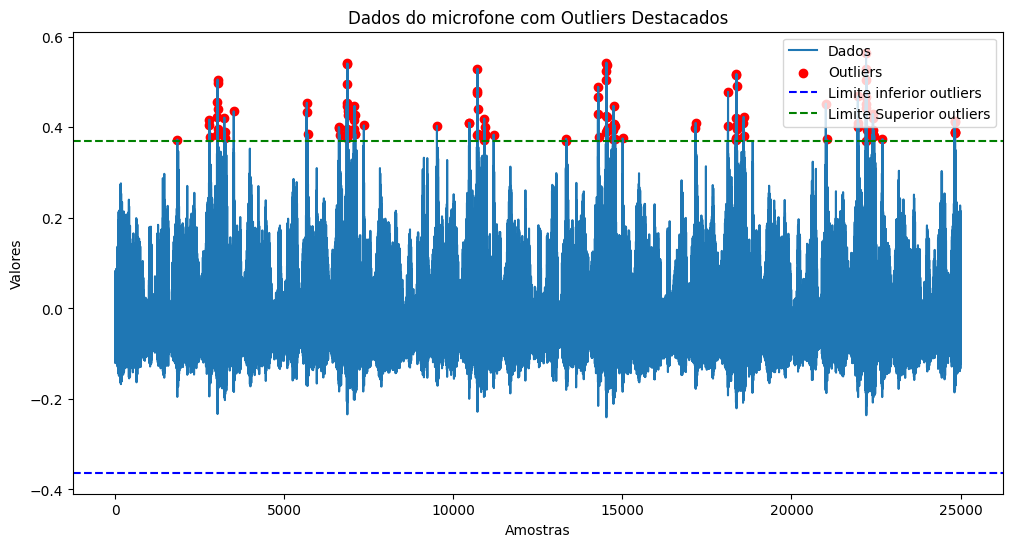

In [ ]:
feature_data = imbalance_sample['microfone']
plot_outliers(feature_data, 'microfone')

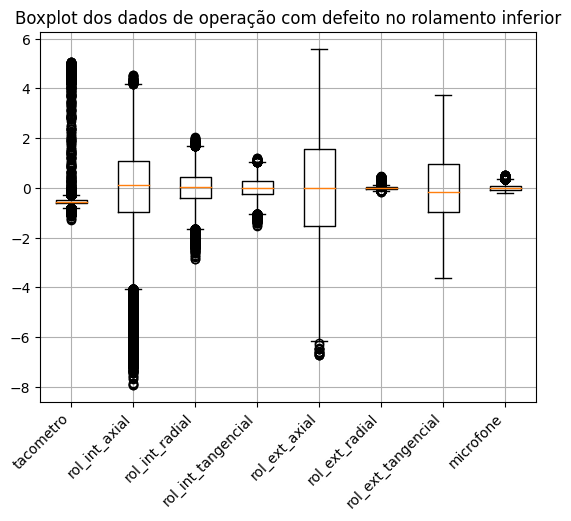

Número de outliers na coluna 0: 38397
Número de outliers na coluna 1: 2927
Número de outliers na coluna 2: 1126
Número de outliers na coluna 3: 324
Número de outliers na coluna 4: 14
Número de outliers na coluna 5: 12474
Número de outliers na coluna 6: 0
Número de outliers na coluna 7: 1115


In [ ]:
underhang_sample = pd.read_csv(BASE_PATH + '/data/underhang/ball_fault/20g/15.36.csv', header=None, names=feature_names)

bp = plt.boxplot(underhang_sample, labels=underhang_sample.columns)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot dos dados de operação com defeito no rolamento inferior')
plt.grid(True)
plt.show()

for feature in range(len(underhang_sample.columns)):
    # Obter os outliers (fliers)
    outliers = bp['fliers'][feature].get_ydata()

    # Contar os outliers
    num_outliers = len(outliers)

    # Imprimir o número de outliers para a feature
    print(f"Número de outliers na coluna {feature}: {num_outliers}")

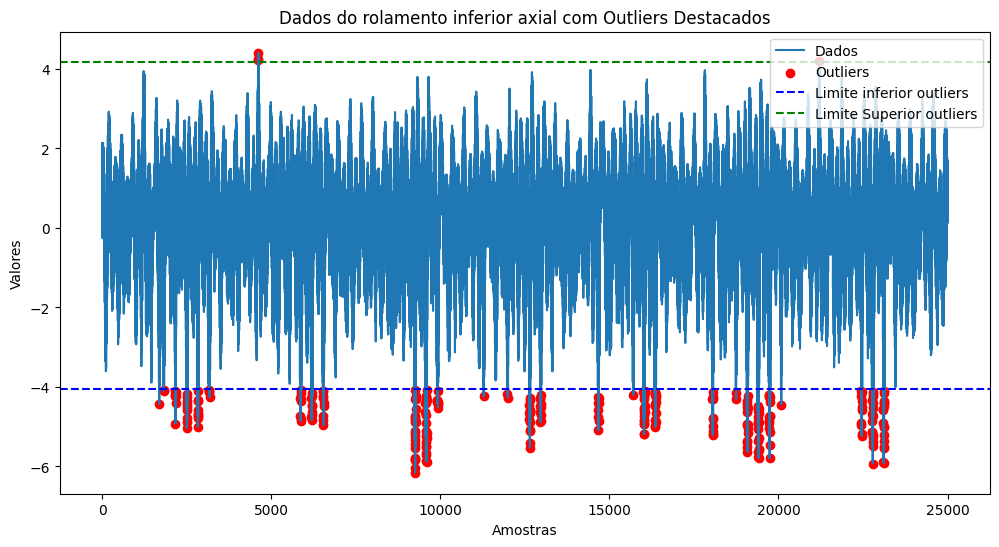

In [ ]:
feature_data = underhang_sample['rol_int_axial']
plot_outliers(feature_data, 'rolamento inferior axial')

# Análise e exploração dos dados

In [ ]:
normal_sample.head()

,tacometro,rol_int_axial,rol_int_radial,rol_int_tangencial,rol_ext_axial,rol_ext_radial,rol_ext_tangencial,microfone
0,-0.73677,-0.81027,0.15131,0.265130,-0.028902,-0.034116,0.31677,-0.12103
1,-0.73709,-1.25840,-0.91427,0.233290,-0.046288,-0.037319,0.26041,0.18275
2,-0.72662,-0.39682,0.54628,0.222700,-0.004793,-0.029894,0.61730,-0.28536
3,-0.74232,-0.83926,-0.57734,-0.076713,-0.030071,-0.036934,0.42859,0.26604
4,-0.72715,-0.14363,0.53314,-0.477420,-0.011421,-0.033314,0.52157,-0.29378


In [ ]:
normal_sample.dtypes

,0
tacometro,float64
rol_int_axial,float64
rol_int_radial,float64
rol_int_tangencial,float64
rol_ext_axial,float64
rol_ext_radial,float64
rol_ext_tangencial,float64
microfone,float64


In [ ]:
normal_sample.describe()

,tacometro,rol_int_axial,rol_int_radial,rol_int_tangencial,rol_ext_axial,rol_ext_radial,rol_ext_tangencial,microfone
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-0.000037,0.002061,-0.000348,0.000613,0.008205,0.002906,0.115704,0.011230
std,1.785603,0.627288,0.505619,0.295160,0.164101,0.036356,0.593672,0.215691
min,-1.422500,-2.925600,-2.204000,-1.523700,-0.800550,-0.129330,-2.025200,-0.472960
25%,-0.751900,-0.411782,-0.346573,-0.196170,-0.098271,-0.021795,-0.300280,-0.171240
50%,-0.727330,0.020503,0.003436,0.001267,0.024407,0.003843,0.130430,-0.007933
75%,-0.612957,0.436710,0.344320,0.196390,0.128650,0.029070,0.537680,0.172360
max,4.920500,2.280700,2.343100,1.658800,0.432870,0.109660,2.273500,0.849900


In [ ]:
imbalance_sample.describe()

,tacometro,rol_int_axial,ro_int_radial,rol_int_tangencial,rol_ext_axial,rol_ext_radial,rol_ext_tangencial,microfone
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-0.000499,0.016254,0.000103,0.000779,0.009088,0.003904,0.085726,0.012278
std,1.585844,1.097578,0.344077,0.046907,0.146979,0.038289,0.860979,0.124477
min,-1.100600,-4.306500,-2.199100,-0.210420,-0.553140,-0.127340,-2.193000,-0.277910
25%,-0.597430,-0.812285,-0.272703,-0.031125,-0.093604,-0.023014,-0.534610,-0.087956
50%,-0.541110,0.167840,0.036446,0.003702,0.012660,0.004068,0.017542,-0.011705
75%,-0.467618,1.013100,0.315230,0.034056,0.122940,0.031105,0.637223,0.095406
max,5.050500,1.715800,0.652900,0.182490,0.372050,0.119940,3.056400,0.683360


In [ ]:
underhang_sample.describe()

,tacometro,rol_int_axial,rol_int_radial,rol_int_tangencial,rol_ext_axial,rol_ext_radial,rol_ext_tangencial,microfone
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-0.000825,0.004045,-0.000616,-0.000245,0.006261,0.001888,-0.015612,0.018107
std,1.620201,1.538240,0.602366,0.356580,1.990002,0.059382,1.193174,0.106651
min,-1.299200,-7.911700,-2.851800,-1.521400,-6.712300,-0.147010,-3.607200,-0.218650
25%,-0.624820,-0.974453,-0.404010,-0.260110,-1.534800,-0.033763,-0.974683,-0.072574
50%,-0.570330,0.104855,0.024565,-0.006029,-0.003913,-0.005680,-0.164970,0.003239
75%,-0.493130,1.083400,0.433737,0.262930,1.568125,0.023532,0.980860,0.096288
max,5.078100,4.545400,2.067800,1.205700,5.594700,0.461760,3.738400,0.519590


In [ ]:
normal_sample.std()

,0
tacometro,1.785603
rol_int_axial,0.627288
rol_int_radial,0.505619
rol_int_tangencial,0.295160
rol_ext_axial,0.164101
rol_ext_radial,0.036356
rol_ext_tangencial,0.593672
microfone,0.215691


In [ ]:
comparative_std = pd.DataFrame({ 'Normal': normal_sample.std(), 'Desbalanceado': imbalance_sample.std(), 'Rolamento inferior': underhang_sample.std()})
comparative_std.style.background_gradient(cmap='Blues')

,Normal,Desbalanceado,Rolamento inferior
tacometro,1.785603,1.585844,1.620201
rol_int_axial,0.627288,1.097578,1.538240
rol_int_radial,0.505619,0.344077,0.602366
rol_int_tangencial,0.295160,0.046907,0.356580
rol_ext_axial,0.164101,0.146979,1.990002
rol_ext_radial,0.036356,0.038289,0.059382
rol_ext_tangencial,0.593672,0.860979,1.193174
microfone,0.215691,0.124477,0.106651


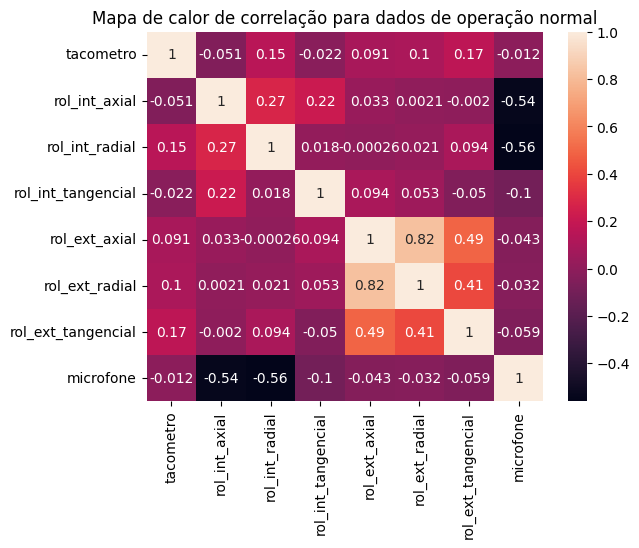

In [ ]:
correlation_matrix = normal_sample.corr()

# Plotar a matriz de correlação como um heatmap
ax =sns.heatmap(correlation_matrix, annot=True)
ax.set_title('Mapa de calor de correlação para dados de operação normal')
plt.show()

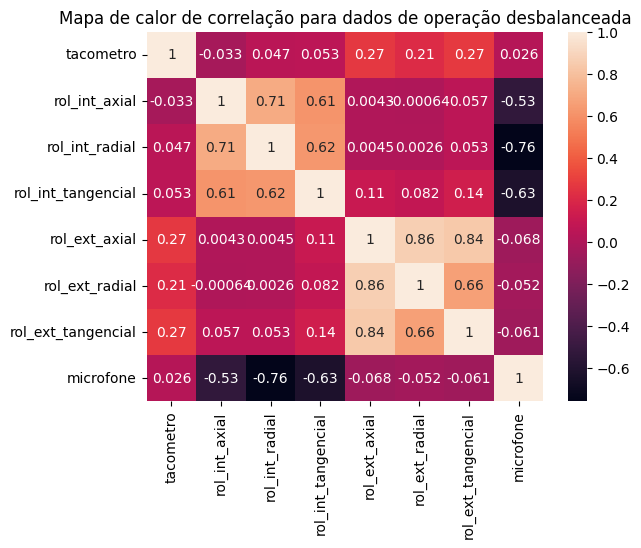

In [ ]:
correlation_matrix = imbalance_sample.corr()

# Plotar a matriz de correlação como um heatmap
ax = sns.heatmap(correlation_matrix, annot=True)
ax.set_title('Mapa de calor de correlação para dados de operação desbalanceada')
plt.show()

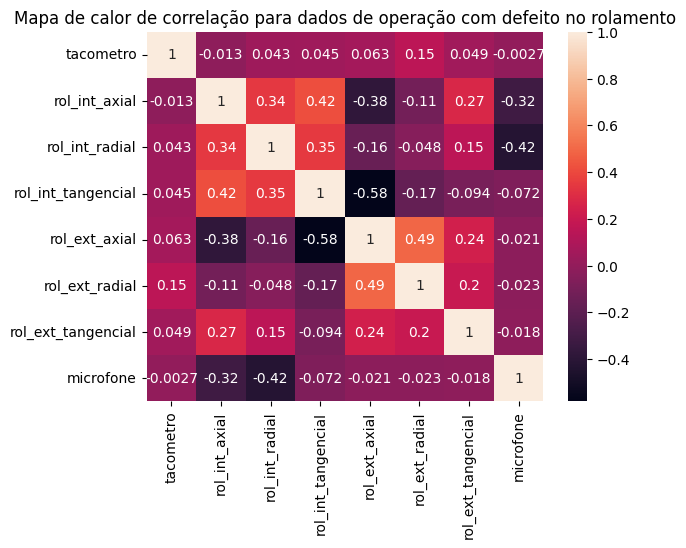

In [ ]:
correlation_matrix = underhang_sample.corr()

# Plotar a matriz de correlação como um heatmap
ax = sns.heatmap(correlation_matrix, annot=True)
ax.set_title('Mapa de calor de correlação para dados de operação com defeito no rolamento')
plt.show()

In [ ]:
def plotSignalSample(data, title):
    timeAxes = np.arange(0 , 1, 1/50000)
    data_1s = data[0:50000]
    figure, axis = plt.subplots(8,1, figsize=(10,15),  constrained_layout=True)
    plt.title(title)

    for i in range(len(data.columns)):
        axis[i].set_title(data.columns[i])
        axis[i].plot(timeAxes, data_1s.iloc[:,i])

    figure.suptitle(title, fontsize=18)
    figure.supxlabel('Seconds')
    figure.supylabel('Voltage')


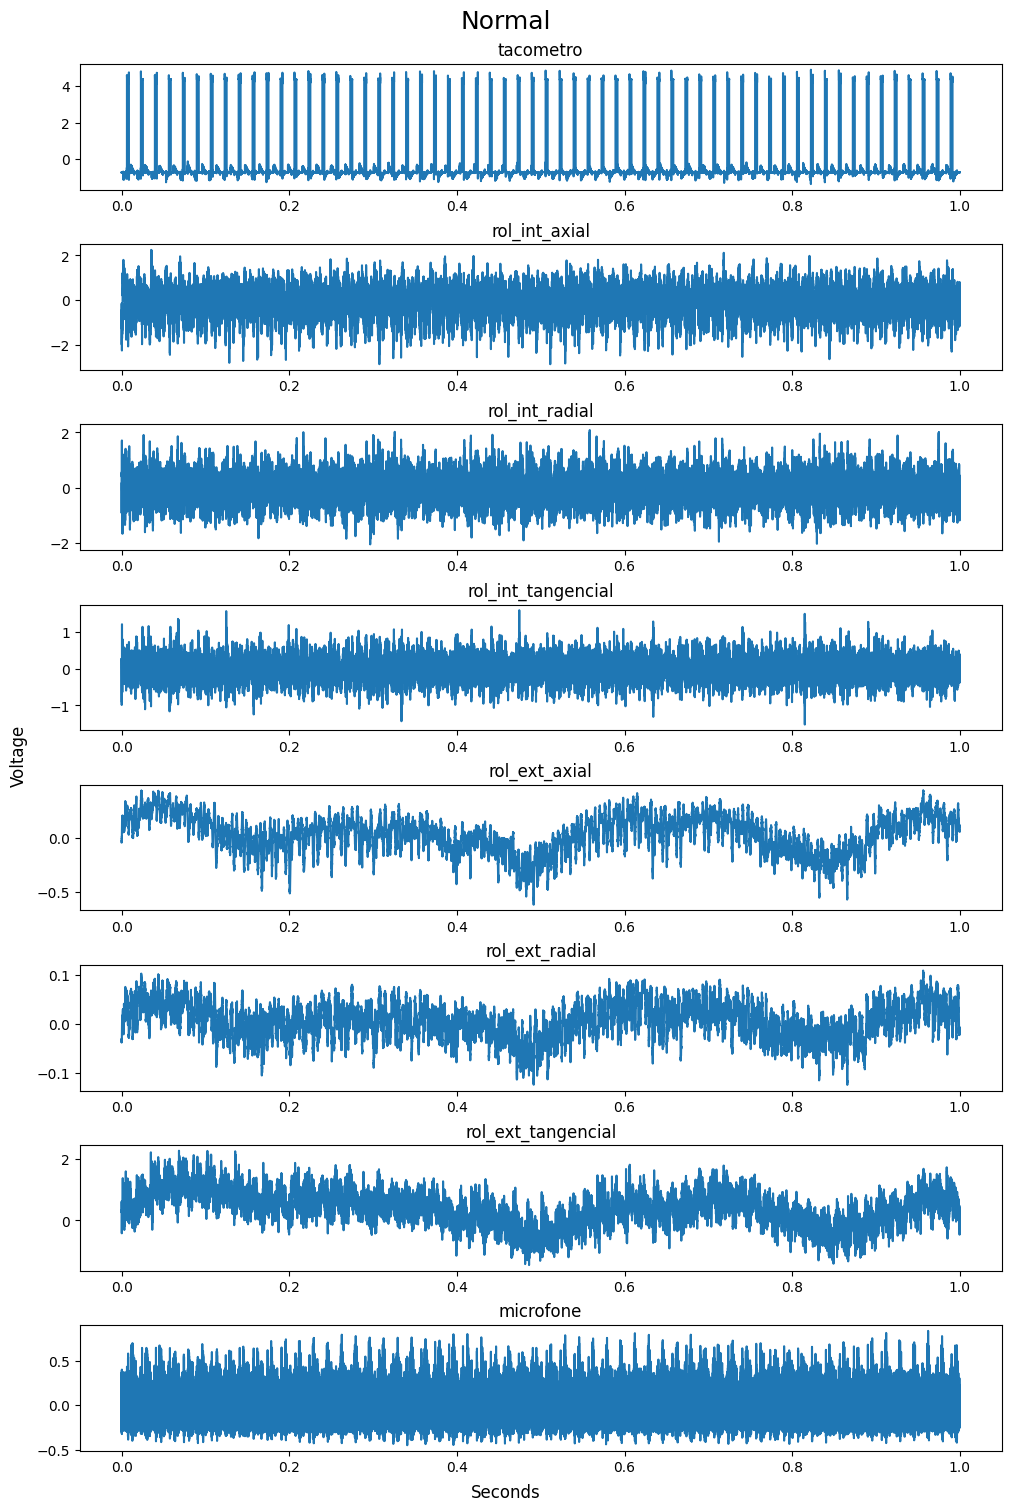

In [ ]:
plotSignalSample(normal_sample, 'Normal')


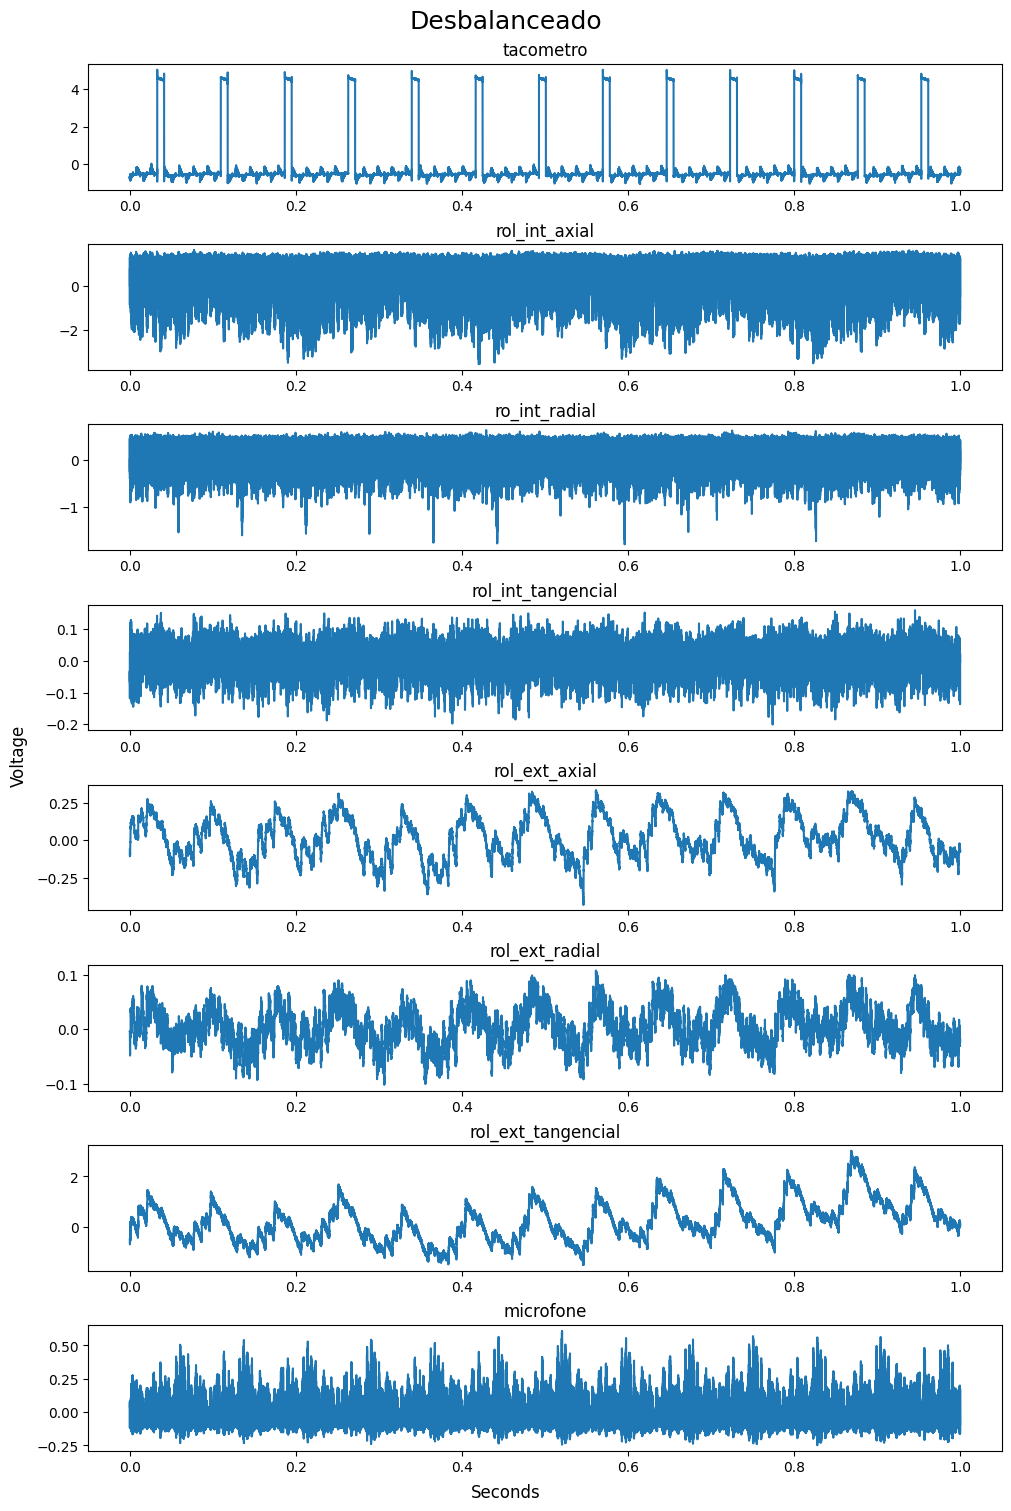

In [ ]:
plotSignalSample(imbalance_sample, 'Desbalanceado')

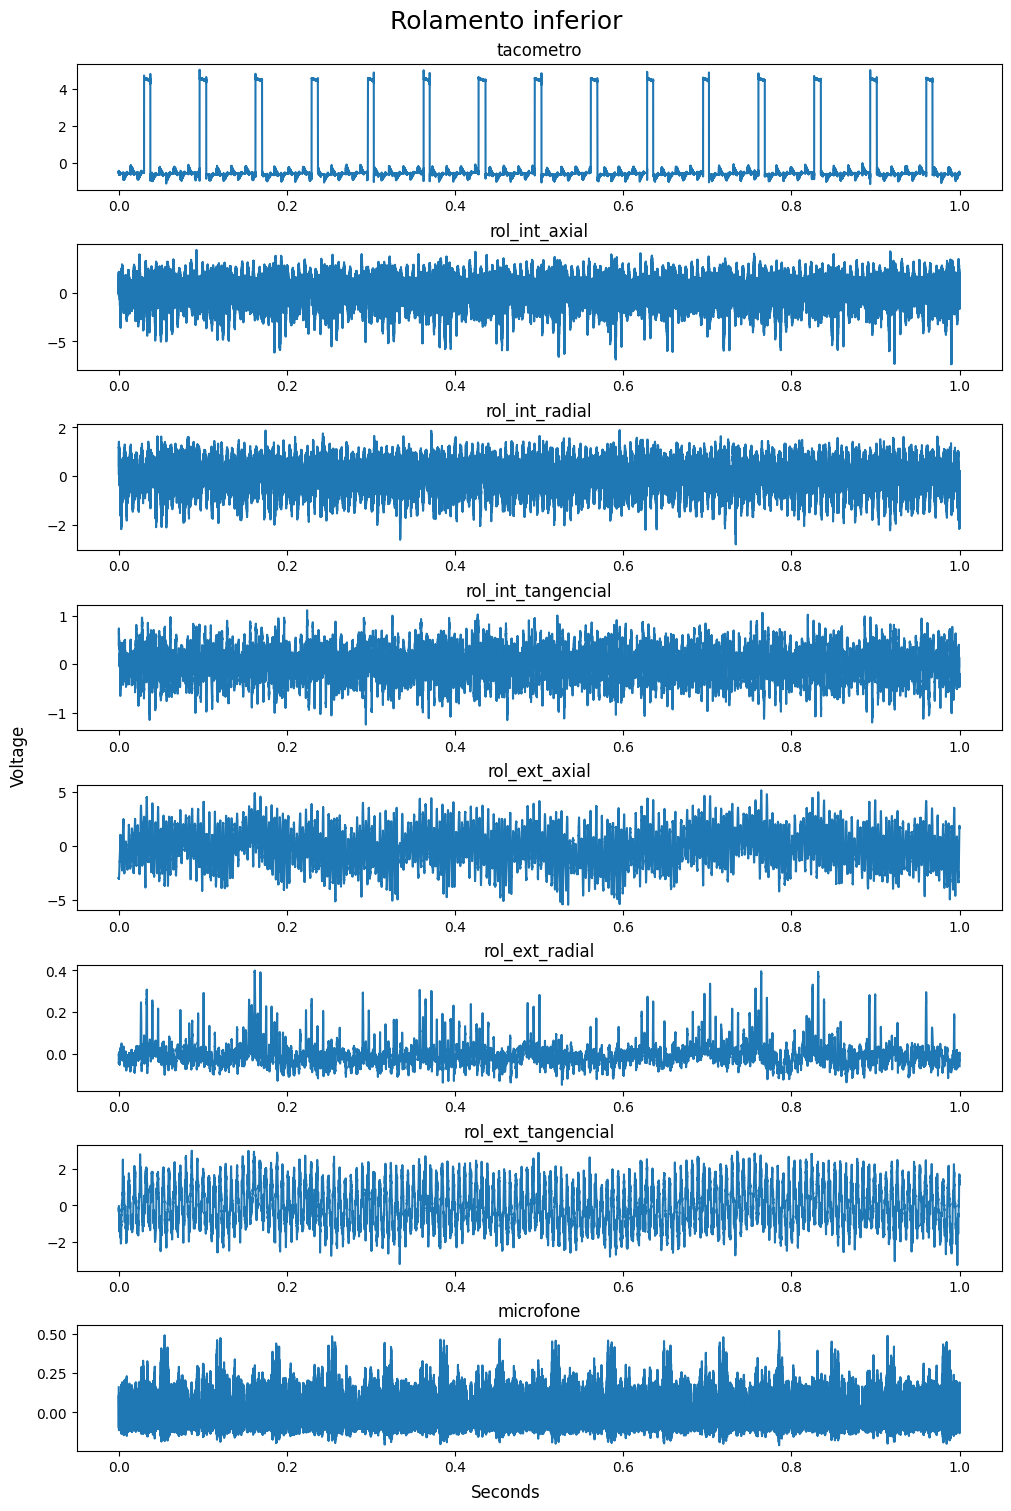

In [ ]:
plotSignalSample(underhang_sample, 'Rolamento inferior')

Deste gráfico chegamos a 2 conclusões:
- Dados não estão na mesma escala, o que pode enviesar o algoritmo de machine learn.
- Alta taxa de amostragem (50kHz), o que tornará o processo de treinamento muito lento.

# Resample


In [ ]:
# taxa de amostragem original dos dados
ORIGINAL_SAMPLE_RATE = 50000

In [ ]:
def apply_rfft(signal, sampling_rate):
    rfft_result = np.abs(np.fft.rfft(signal, axis=0))[1:,:]
    rfft_freqs = np.fft.rfftfreq(len(signal), d=1/sampling_rate)[1:]

    return rfft_result, rfft_freqs

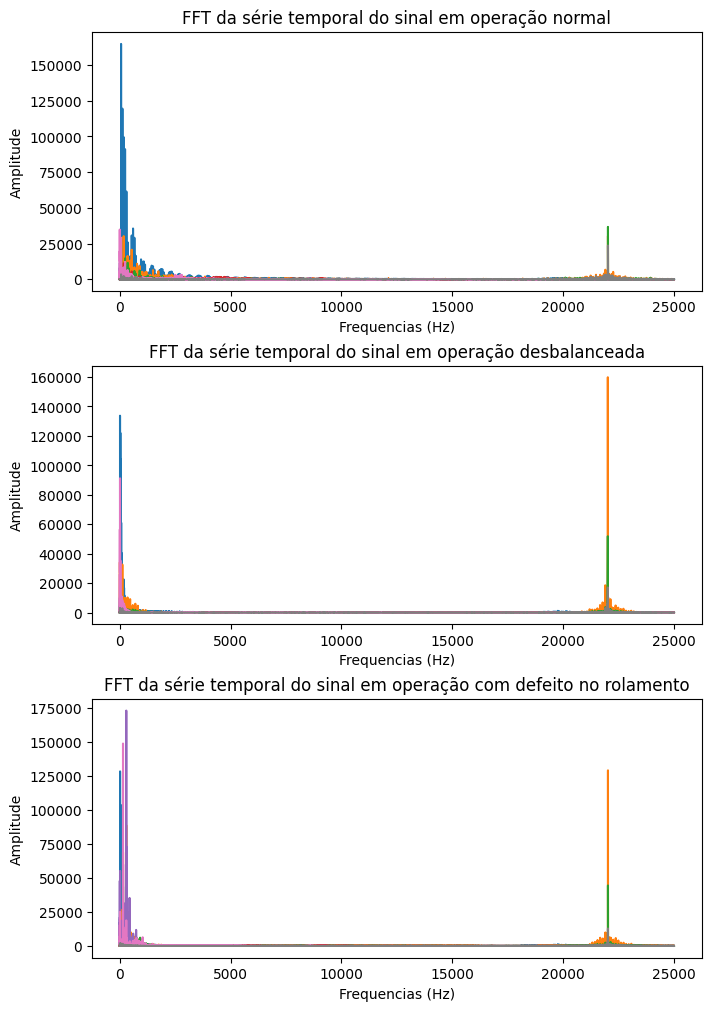

In [ ]:
normal_sample_fft, normal_sample_fft_freq = apply_rfft(normal_sample, ORIGINAL_SAMPLE_RATE)
imbalance_sample_fft, imbalance_sample_fft_freq = apply_rfft(imbalance_sample, ORIGINAL_SAMPLE_RATE)
underhang_sample_fft, underhang_sample_fft_freq = apply_rfft(underhang_sample, ORIGINAL_SAMPLE_RATE)

figure, axis = plt.subplots(3,1, figsize=(7,10),  constrained_layout=True)

axis[0].plot(normal_sample_fft_freq, normal_sample_fft)
axis[0].set_xlabel('Frequencias (Hz)')
axis[0].set_ylabel('Amplitude')
axis[0].set_title('FFT da série temporal do sinal em operação normal')

axis[1].plot(imbalance_sample_fft_freq, imbalance_sample_fft)
axis[1].set_xlabel('Frequencias (Hz)')
axis[1].set_ylabel('Amplitude')
axis[1].set_title('FFT da série temporal do sinal em operação desbalanceada')

axis[2].plot(underhang_sample_fft_freq, underhang_sample_fft)
axis[2].set_xlabel('Frequencias (Hz)')
axis[2].set_ylabel('Amplitude')
axis[2].set_title('FFT da série temporal do sinal em operação com defeito no rolamento')

figure.show()

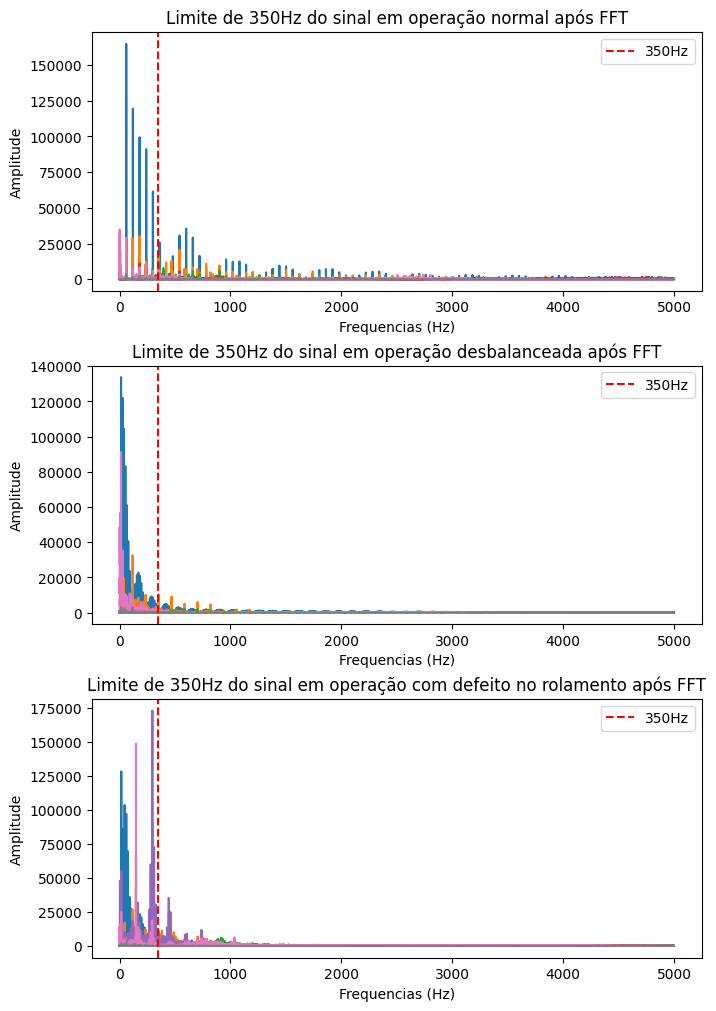

In [ ]:
figure, axis = plt.subplots(3,1, figsize=(7,10),  constrained_layout=True)
axis[0].plot(normal_sample_fft_freq[:25000], normal_sample_fft[:25000])
axis[0].axvline(x=350, color='red', linestyle='--', label='350Hz')
axis[0].set_xlabel('Frequencias (Hz)')
axis[0].set_ylabel('Amplitude')
axis[0].set_title('Limite de 350Hz do sinal em operação normal após FFT')
axis[0].legend()

axis[1].plot(imbalance_sample_fft_freq[:25000], imbalance_sample_fft[:25000])
axis[1].axvline(x=350, color='red', linestyle='--', label='350Hz')
axis[1].set_xlabel('Frequencias (Hz)')
axis[1].set_ylabel('Amplitude')
axis[1].set_title('Limite de 350Hz do sinal em operação desbalanceada após FFT')
axis[1].legend()

axis[2].plot(underhang_sample_fft_freq[:25000], underhang_sample_fft[:25000])
axis[2].axvline(x=350, color='red', linestyle='--', label='350Hz')
axis[2].set_xlabel('Frequencias (Hz)')
axis[2].set_ylabel('Amplitude')
axis[2].set_title('Limite de 350Hz do sinal em operação com defeito no rolamento após FFT')
axis[2].legend()

figure.show()

A maioria das frequencias com maior amplitude se encontram até 350 Hz. Aceitando alguma perda nos dados, essa será definida como a maior frequencia que compõe o sinal original. Portando a frequenca de Nyquist será de  700Hz.

In [ ]:
TARGET_RATE = 700

In [ ]:
def resample_signal(signal_data, original_sr, target_sr):
  num_channels = signal_data.shape[1]
  num_samples = int(signal_data.shape[0] * target_sr / original_sr)
  resampled_data = np.zeros((num_samples, num_channels))

  for channel_index in range(num_channels):
    channel_signal = signal_data[:, channel_index]  # Obtém o sinal do canal atual

    # cria um filtro passa-baixa para evitar aliasing
    cutoff_freq = target_sr / 2  # Frequência de corte (metade da nova taxa de amostragem)
    b, a = signal.butter(2, cutoff_freq / (original_sr / 2), 'lowpass')  # Cria um filtro Butterworth

    # Aplica o filtro ao sinal
    channel_signal = signal.lfilter(b, a, channel_signal)

    # realiza a reamostragem do sinal
    resampled_signal = signal.resample(channel_signal, num_samples)
    resampled_data[:, channel_index] = resampled_signal

  return resampled_data

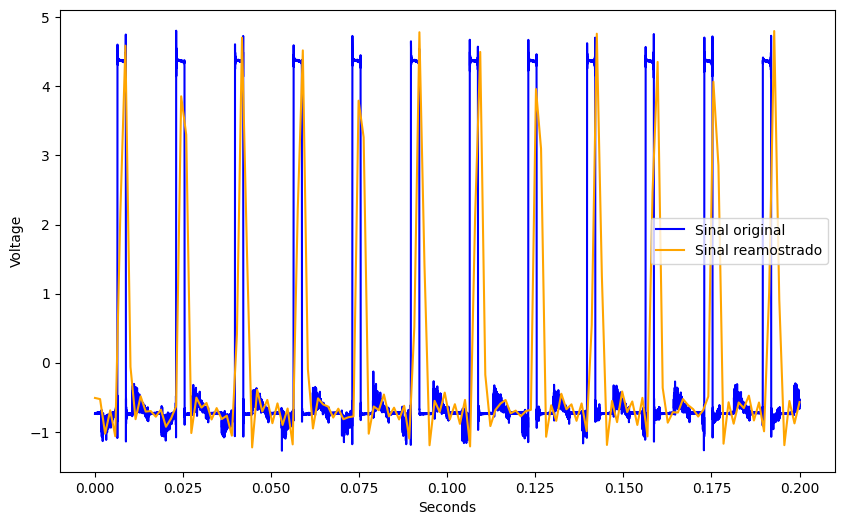

In [ ]:
# reamostra do sinal
resampled_signal = resample_signal(normal_sample.to_numpy(), ORIGINAL_SAMPLE_RATE, TARGET_RATE)

# define intervalo de 2s para ser plotado
# calcula quantidade de amostras dos sinais dentro do intervalo de tempo definido
time = 0.2 # s
qty_original_samples = int(ORIGINAL_SAMPLE_RATE * time)
qty_resampled_sample = int(TARGET_RATE * time)
t1 = np.linspace(0, time, qty_original_samples)
t2 = np.linspace(0, time, qty_resampled_sample)

# plota grafico comparando os dados do tacômetro do sinal original e do reamostrado
plt.figure(figsize=(10, 6))
plt.plot(t1,  normal_sample['tacometro'][0:qty_original_samples], label='Sinal original', color='blue')
plt.plot(t2,  resampled_signal[0:qty_resampled_sample, 0], label='Sinal reamostrado', color='orange')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.legend()
plt.show()

## processamento de dados
aqui os dados serão tratados para uso nos modelos de machine learn

In [ ]:
def process_data(files_folder):
  processed_data = []

  for i in range(len(files_folder)):
    data = pd.read_csv(files_folder[i], header=None)
    data = data.to_numpy();
    signal_resampled = resample_signal(data, ORIGINAL_SAMPLE_RATE, TARGET_RATE)
    spectrum, xf = apply_rfft(signal_resampled, TARGET_RATE)

    processed_data.append(spectrum)

  return np.array(processed_data)

In [ ]:
import pickle

data_normal = process_data( glob.glob(BASE_PATH + '/data/normal/*.csv'))
file_path = BASE_PATH + '/processed data/normal.pkl'
with open(file_path, 'wb') as f:
   pickle.dump(data_normal, f)

data_imbalance= process_data( glob.glob(BASE_PATH + '/data/imbalance/**/*.csv'))
file_path = BASE_PATH + '/processed data/imbalance.pkl'
with open(file_path, 'wb') as f:
   pickle.dump(data_imbalance, f)

data_underhang = process_data( glob.glob(BASE_PATH + '/data/underhang/**/*.csv', recursive=True))
file_path = BASE_PATH + '/processed data/underhang.pkl'
with open(file_path, 'wb') as f:
   pickle.dump(data_underhang, f)


In [ ]:
import pickle

data_normal = pickle.load(open(BASE_PATH + '/processed data/normal.pkl', 'rb'))
data_imbalance = pickle.load(open(BASE_PATH + '/processed data/imbalance.pkl', 'rb'))
data_underhang = pickle.load(open(BASE_PATH + '/processed data/underhang.pkl', 'rb'))

In [ ]:
X = np.concatenate((
    data_normal,
    data_imbalance,
    data_underhang
    ), axis=0)

y_classes = np.concatenate((
    np.full(data_normal.shape[0], 'normal'),
    np.full(data_imbalance.shape[0], 'imbalance'),
    np.full(data_underhang.shape[0], 'underhang')
    ), axis=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_classes)


X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=1)

In [ ]:
X_train.shape

(705, 1750, 8)

In [ ]:
X_test.shape

(235, 1750, 8)

# Treinamento de Machine Learn

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, classification_report
import seaborn as sns

def plot_model_performance(y_test, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues',cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    class_report = classification_report(y_test, y_pred, target_names=classes, digits=4)
    print(class_report)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
mapped_dict = {label_encoder.inverse_transform([k])[0]: v for k, v in class_weights_dict.items()}
print(mapped_dict)

# LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
%%time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
import pprint

n_samples, timesteps, features = X_train.shape

def create_lstm_model(lstm_units, optimizer, activation, dense_units):
    model = Sequential()
    model.add(Input(shape=(timesteps, features)))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(units=dense_units,  activation=activation))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model = KerasClassifier(model=create_lstm_model, verbose=1, epochs=30, callbacks=[early_stopping])

param_grid = {
    'model__lstm_units': [50, 100, 200],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation':['relu', 'softmax'],
    'model__dense_units':[12, 16, 20],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, y_train, class_weight=class_weights_dict)
LSTM_model = grid_result.best_estimator_.model_

print(f"Acurácia {grid_result.best_score_ * 100:.2f}% com dados de treino, usando parâmetros: "
  f"\n\n{pprint.pformat(grid_result.best_params_)}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.80141844
        nan        nan 0.84964539 0.79432624        nan        nan
 0.97588652 0.97304965 0.98297872 0.97730496 0.97588652 0.98439716
 0.98156028 0.98865248 0.98297872 0.99007092 0.97304965 0.9787234
 0.97446809 0.98014184 0.98297872 0.9858156  0.92056738        nan]
  warnings.warn(


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5283 - loss: 1.8014
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9181 - loss: 0.4550
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9243 - loss: 0.3060
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9696 - loss: 0.1363
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9593 - loss: 0.1434
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9827 - loss: 0.0655
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9775 - loss: 0.0754
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9763 - loss: 0.1057
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9685 - loss: 0.1131
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9795 - loss: 0.0990
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9800 - loss: 0.0626
Acurácia 99.01% com dados de treino, usando parâmetros: 

{'mod

In [ ]:
import pickle

with open(BASE_PATH + '/models/lstm.pkl', 'wb') as file:
    pickle.dump(LSTM_model, file)


In [ ]:
import pickle
LSTM_model = pickle.load(open(BASE_PATH + '/models/lstm.pkl', 'rb'))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


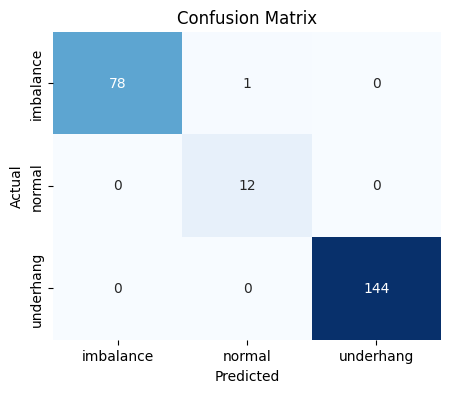

              precision    recall  f1-score   support

   imbalance     1.0000    0.9873    0.9936        79
      normal     0.9231    1.0000    0.9600        12
   underhang     1.0000    1.0000    1.0000       144

    accuracy                         0.9957       235
   macro avg     0.9744    0.9958    0.9845       235
weighted avg     0.9961    0.9957    0.9958       235



In [ ]:
from sklearn.metrics import classification_report

y_pred = LSTM_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plot_model_performance(y_test, y_pred_classes, label_encoder.classes_)

# CNN


In [ ]:
%%time
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
import pprint

n_samples, timesteps, features = X_train.shape

def create_model(filters, kernel_size, pool_size, dense_units, activation_conv, activation_dense1, activation_dense2):
    model = Sequential()
    model.add(Input(shape=(timesteps, features)))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation_conv))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation_dense1))
    model.add(Dense(3, activation=activation_dense2))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model = KerasClassifier(model=create_model, epochs=30, batch_size=32, verbose=2, callbacks=[early_stopping])

param_grid = {
    'model__filters': [32, 64],
    'model__kernel_size': [3, 5],
    'model__pool_size': [2, 3],
    'model__dense_units': [64, 128],
    'model__activation_conv':['relu', 'softmax'],
    'model__activation_dense1':['relu', 'softmax'],
    'model__activation_dense2':['relu', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, return_train_score=True)

grid_result_CNN = grid.fit(X_train, y_train, class_weight=class_weights_dict)
CNN_model = grid_result_CNN.best_estimator_.model_

print(f"Acurácia {grid_result_CNN.best_score_ * 100:.2f}% com dados de treino, usando parâmetros:"
  f"\n\n{pprint.pformat(grid_result_CNN.best_params_)}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Epoch 1/30
23/23 - 4s - 180ms/step - accuracy: 0.8809 - loss: 0.3780
Epoch 2/30
23/23 - 0s - 3ms/step - accuracy: 0.9858 - loss: 0.0716
Epoch 3/30
23/23 - 0s - 3ms/step - accuracy: 0.9957 - loss: 0.0181
Epoch 4/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 5/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 6/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 7.1902e-04
Epoch 7/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 5.8323e-04
Epoch 8/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 4.9576e-04
Epoch 9/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 4.3616e-04
Epoch 10/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 3.8116e-04
Epoch 11/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 3.4192e-04
Epoch 12/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 3.0564e-04
Epoch 13/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 2.7160e-04
Epoch 14/30
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 2.4653e-04
Epoch 15/30
23/23 -

In [ ]:
import pickle

with open(BASE_PATH + '/models/CNN_model.pkl', 'wb') as file:
    pickle.dump(CNN_model, file)

In [ ]:
import pickle
CNN_model = pickle.load(open(BASE_PATH + '/models/CNN_model.pkl', 'rb'))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


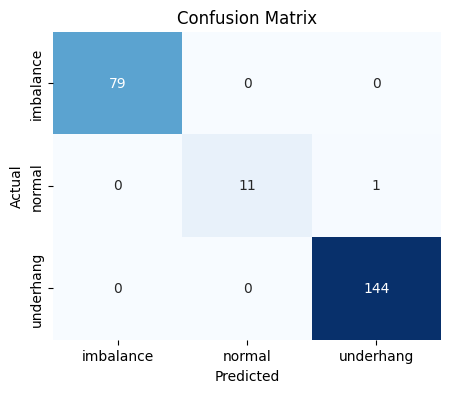

              precision    recall  f1-score   support

   imbalance     1.0000    1.0000    1.0000        79
      normal     1.0000    0.9167    0.9565        12
   underhang     0.9931    1.0000    0.9965       144

    accuracy                         0.9957       235
   macro avg     0.9977    0.9722    0.9844       235
weighted avg     0.9958    0.9957    0.9957       235



In [ ]:
y_pred = CNN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plot_model_performance(y_test, y_pred_classes, label_encoder.classes_)

# GRU

In [ ]:
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Input, GRU
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
import pprint

n_samples, timesteps, features = X_train.shape

# Definir a função para criar o modelo GRU
def create_gru_model(gru_units, dense_units, dense_activation, optimizer):
    model = Sequential()
    model.add(Input(shape=(timesteps, features)))
    model.add(GRU(units=gru_units))
    model.add(Dense(units=dense_units, activation=dense_activation))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model = KerasClassifier(model=create_gru_model, verbose=1, epochs=20, callbacks=[early_stopping])

param_grid = {
    'model__gru_units': [128, 256],
    'model__dense_units': [4, 8],
    'model__dense_activation':['softmax', 'relu'],
    'model__optimizer': ['adam', 'rmsprop'],
}

# Criar o objeto GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, return_train_score=True)

# Ajustar o GridSearchCV aos dados de treinamento
grid_result_GRU = grid.fit(X_train, y_train,  class_weight=class_weights_dict, verbose=1)
GRU_model = grid_result_GRU.best_estimator_.model_

# Imprimir os melhores hiperparâmetros
print(f"Acurácia {grid_result_GRU.best_score_ * 100:.2f}% com dados de treino, usando parâmetros:"
  f"\n\n{pprint.pformat(grid_result_GRU.best_params_)}")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.97304965 0.96170213 0.97446809 0.9787234  0.98723404 0.98439716
 0.98865248 0.98014184 0.46666667 0.44397163 0.36170213 0.36312057
        nan        nan 0.59716312        nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the train scores are non-finite: [0.98652482 0.95957447 0.98297872 0.99361702 0.99432624 0.99078014
 0.99432624 0.9964539  0.48652482 0.46312057 0.36099291 0.36170213
        nan 0.5070922  0.60212766 0.49361702]
  warnings.warn(


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5023 - loss: 1.3996
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8966 - loss: 0.3297
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9600 - loss: 0.1377
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8611 - loss: 0.2973
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9564 - loss: 0.0959
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9838 - loss: 0.0478
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9665 - loss: 0.0920
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9773 - loss: 0.0744
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9897 - loss: 0.0315
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9923 - loss: 0.0256
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9906 - loss: 0.0241
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy:

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


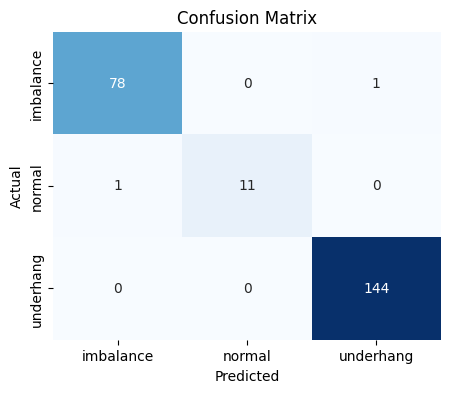

              precision    recall  f1-score   support

   imbalance     0.9873    0.9873    0.9873        79
      normal     1.0000    0.9167    0.9565        12
   underhang     0.9931    1.0000    0.9965       144

    accuracy                         0.9915       235
   macro avg     0.9935    0.9680    0.9801       235
weighted avg     0.9915    0.9915    0.9914       235



In [ ]:
y_pred = GRU_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plot_model_performance(y_test, y_pred_classes, label_encoder.classes_)

In [ ]:
import pickle

with open(BASE_PATH + '/models/GRU_model.pkl', 'wb') as file:
    pickle.dump(GRU_model, file)